# Import library and Load data


In [ ]:
# Mengimport semua package yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files

In [ ]:
# Memuat data dari URL
url = 'https://raw.githubusercontent.com/Sidqixx/DataMining/main/economic_impact_on_emissions_modified.csv'
economic_impact_df = pd.read_csv(url)  # Membaca file CSV berisi data dampak ekonomi terhadap emisi
url2 = 'https://raw.githubusercontent.com/Sidqixx/DataMining/main/Carbon_(CO2)_Emissions_by_Country.csv'
co2_emissions_df= pd.read_csv(url2)  # Membaca file CSV berisi data emisi karbon (CO2) berdasarkan negara

In [ ]:
# Melihat data (kolom dan 10 baris pertama)
print(economic_impact_df.columns)  # Menampilkan nama kolom pada dataset economic_impact_df
print(economic_impact_df.head(10))  # Menampilkan 10 baris pertama dari dataset economic_impact_df
print(co2_emissions_df.columns)  # Menampilkan nama kolom pada dataset co2_emissions_df
print(co2_emissions_df.head(10))  # Menampilkan 10 baris pertama dari dataset co2_emissions_df

Index(['Country', 'GDP_per_Capita', 'Fuel_Price', 'Population_Density',
       'Urbanization_Rate', 'CO2_Emissions', 'Emission_Category'],
      dtype='object')
          Country  GDP_per_Capita  Fuel_Price  Population_Density  \
0  United Kingdom    1.798785e+04    2.527788          503.253640   
1          Taiwan    3.728207e+04    4.471067          412.607329   
2          Mexico    5.479929e+04    0.975621          953.489821   
3       Australia    9.207855e+03    4.947239          527.314320   
4          France    6.946882e+03    2.494729          226.926305   
5    South Africa    1.610492e+04    0.715239          464.373845   
6             NaN    1.026161e+08    0.671098          920.193531   
7          Turkey    3.598481e+04    3.857933          184.334517   
8       Australia    7.030547e+03    3.465660          221.817468   
9       Australia    5.520628e+04    4.109588           22.899272   

   Urbanization_Rate  CO2_Emissions Emission_Category  
0           9.216796   

# Prepare Data

### Penambahan ID unik

In [ ]:
# Mengurutkan data berdasarkan nama negara
economic_impact_df = economic_impact_df.sort_values(by='Country').reset_index(drop=True)  # Mengurutkan dataset economic_impact_df berdasarkan kolom 'Country' dan mereset indeks
co2_emissions_df = co2_emissions_df.sort_values(by='Country').reset_index(drop=True)  # Mengurutkan dataset co2_emissions_df berdasarkan kolom 'Country' dan mereset indeks

# Menghapus data jika nama negara tidak cocok di kedua dataset
economic_impact_df = economic_impact_df[economic_impact_df['Country'].isin(co2_emissions_df['Country'])]  # Menyimpan data dengan nama negara yang cocok di co2_emissions_df
co2_emissions_df = co2_emissions_df[co2_emissions_df['Country'].isin(economic_impact_df['Country'])]  # Menyimpan data dengan nama negara yang cocok di economic_impact_df

# Fungsi untuk menghasilkan ID unik untuk setiap negara
def generate_country_ids(df, id_column, id_prefix):
    unique_countries = df['Country'].drop_duplicates().reset_index(drop=True)  # Menghapus duplikasi pada kolom 'Country' dan mereset indeks
    country_id_map = {country: f"{id_prefix}{str(i + 1).zfill(3)}" for i, country in enumerate(unique_countries)}  # Membuat peta ID unik dengan prefix dan angka 3 digit
    df[id_column] = df['Country'].map(country_id_map)  # Menambahkan kolom baru dengan ID unik berdasarkan peta
    return df, country_id_map

# Menerapkan ID unik pada kedua dataset
economic_impact_df, economic_id_map = generate_country_ids(economic_impact_df, 'Country_ID', 'CID')  # Menambahkan kolom 'Country_ID' dengan prefix 'CID' pada economic_impact_df
co2_emissions_df, co2_id_map = generate_country_ids(co2_emissions_df, 'Country_ID', 'CID')  # Menambahkan kolom 'Country_ID' dengan prefix 'CID' pada co2_emissions_df

# Mengecek jumlah nilai unik pada kolom nama negara dan Country_ID
unique_countries_economic = economic_impact_df[['Country', 'Country_ID']].drop_duplicates()  # Menyimpan kombinasi unik 'Country' dan 'Country_ID' di economic_impact_df
unique_countries_co2 = co2_emissions_df[['Country', 'Country_ID', 'Region']].drop_duplicates()  # Menyimpan kombinasi unik 'Country', 'Country_ID', dan 'Region' di co2_emissions_df

print("\nJumlah nilai unik pada kolom nama negara dan Country_ID (Economic Impact):")
print(unique_countries_economic)  # Menampilkan data unik negara dan ID dari economic_impact_df
print(f"Total unik: {len(unique_countries_economic)}")  # Menampilkan jumlah total nilai unik
print("\nJumlah nilai unik pada kolom nama negara dan Country_ID (CO2 Emissions):")
print(unique_countries_co2)  # Menampilkan data unik negara, ID, dan region dari co2_emissions_df
print(f"Total unik: {len(unique_countries_co2)}")  # Menampilkan jumlah total nilai unik


Jumlah nilai unik pada kolom nama negara dan Country_ID (Economic Impact):
            Country Country_ID
0         Australia     CID001
35           Brazil     CID002
73           Canada     CID003
112           China     CID004
157          France     CID005
205         Germany     CID006
251           India     CID007
303       Indonesia     CID008
344           Italy     CID009
390           Japan     CID010
447          Mexico     CID011
499     Netherlands     CID012
550          Russia     CID013
598    Saudi Arabia     CID014
632    South Africa     CID015
676     South Korea     CID016
717           Spain     CID017
796          Turkey     CID018
848  United Kingdom     CID019
889   United States     CID020
Total unik: 20

Jumlah nilai unik pada kolom nama negara dan Country_ID (CO2 Emissions):
             Country Country_ID    Region
240        Australia     CID001   Oceania
690           Brazil     CID002  Americas
930           Canada     CID003  Americas
1050           C

### Pembersihan Data (menghapus duplikasi, mengganti value NaN dengan Mean, pengisian column Emission Categoy)

In [ ]:
# Menggabungkan dataset berdasarkan Country_ID
merged_df = pd.merge(economic_impact_df, co2_emissions_df, on='Country_ID', how='inner', suffixes=('_eco', '_co2'))
# Menggabungkan dataset economic_impact_df dan co2_emissions_df berdasarkan kolom 'Country_ID' dengan metode inner join

# Mengecek duplikasi
duplicates = merged_df.duplicated().sum()  # Menghitung jumlah baris duplikat
print(f"\nNumber of duplicate rows: {duplicates}")

# Jika ada duplikasi, hapus
if duplicates > 0:
    merged_df.drop_duplicates(inplace=True)  # Menghapus baris duplikat dari dataset
    print("Duplicates removed.")

# Menangani nilai hilang (missing values)
# Mengecek nilai hilang di setiap kolom
missing_values = merged_df.isnull().sum()  # Menghitung jumlah nilai hilang di setiap kolom
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])  # Menampilkan kolom yang memiliki nilai hilang

# Memisahkan kolom numerik dan kategori
numeric_cols = merged_df.select_dtypes(include=['number']).columns  # Menyimpan kolom dengan tipe data numerik
categorical_cols = merged_df.select_dtypes(include=['object']).columns  # Menyimpan kolom dengan tipe data objek (kategori)

# Mengisi nilai hilang dengan rata-rata regional hanya untuk kolom numerik
for col in numeric_cols:
    merged_df[col] = merged_df.groupby('Region')[col].transform(lambda x: x.fillna(x.mean()))
    # Mengisi nilai kosong pada kolom numerik berdasarkan rata-rata di setiap 'Region'

# Mengisi kolom Emission_Category menggunakan fungsi classify_emissions yang lebih kompleks
def classify_emissions(emission, gdp, fuel_price, density, urban_rate):
    # Mengklasifikasikan kategori emisi berdasarkan nilai CO2_Emissions dan indikator lainnya
    if emission < 100 or (gdp < 10000 and fuel_price > 3):
        return 'Low'  # Kategori rendah
    elif (100 <= emission < 300) or (density > 500 and urban_rate > 50):
        return 'Medium'  # Kategori sedang
    elif emission >= 300 or (fuel_price < 2 and gdp > 50000):
        return 'High'  # Kategori tinggi

# Menerapkan fungsi classify_emissions untuk mengisi kolom Emission_Category
merged_df['Emission_Category'] = merged_df.apply(
    lambda row: classify_emissions(
        row['CO2_Emissions'],  # Nilai emisi CO2
        row['GDP_per_Capita'],  # GDP per kapita
        row['Fuel_Price'],  # Harga bahan bakar
        row['Population_Density'],  # Kepadatan populasi
        row['Urbanization_Rate']  # Tingkat urbanisasi
    ), axis=1
)

# Memastikan bahwa pengisian nilai hilang berhasil
def check_missing_values(df):
    missing = df.isnull().sum()  # Menghitung nilai hilang setelah pengisian
    print("\nCek nilai hilang setelah pengisian:")
    print(missing[missing > 0])  # Menampilkan hanya kolom yang masih memiliki nilai hilang

check_missing_values(merged_df)  # Memeriksa nilai hilang setelah pengisian


Number of duplicate rows: 0

Missing values in each column:
GDP_per_Capita        1350
Fuel_Price            1350
Population_Density    1320
Urbanization_Rate     1410
CO2_Emissions         1380
Emission_Category     1440
dtype: int64

Cek nilai hilang setelah pengisian:
Series([], dtype: int64)


### Persiapan Data untuk modeling, Menerapkan SMOTE dan Normalisasi/Standarisasi

Remaining NaN values: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution before SMOTE:
 Emission_Category
Medium    11307
High       7025
Low        3436
Name: count, dtype: int64
Class distribution after SMOTE:
 Emission_Category
High      11307
Medium    11307
Low       11307
Name: count, dtype: int64


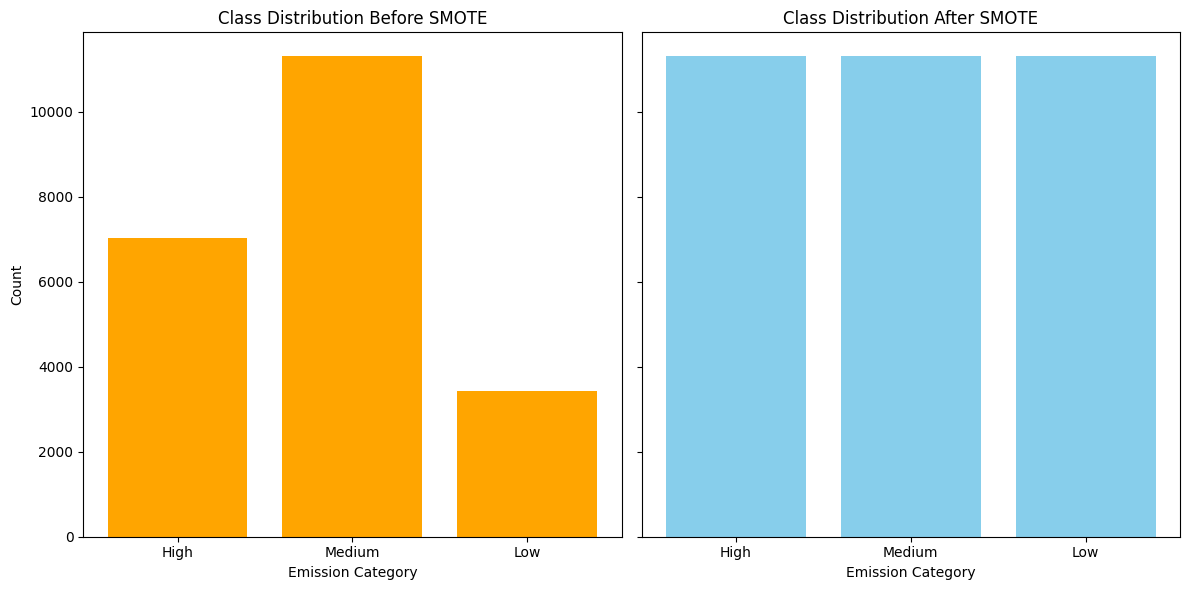


Imbalance ratio (minority/majority): 1.00


In [ ]:
# Menyiapkan data untuk pemodelan
X = merged_df.drop(columns=['Emission_Category'])  # Fitur
y = merged_df['Emission_Category']  # Target

# Mengonversi variabel kategori menjadi variabel dummy
X = pd.get_dummies(X, drop_first=True)

# Membagi data menjadi data latih (training) dan data uji (testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Memastikan tidak ada value NaN
print(f"Remaining NaN values: {X_train.isnull().sum().sum()}")  # This should print 0

# Normalisasi/Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Menerapkan SMOTE untuk menangani ketidakseimbangan kelas
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Mengecek distribusi kelas sebelum dan sesudah SMOTE
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("Class distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())

# Hitung distribusi kelas
original_distribution = Counter(y_train)
resampled_distribution = Counter(y_train_resampled)

# Visualisasi distribusi kelas sebelum dan sesudah SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Sebelum SMOTE
axes[0].bar(original_distribution.keys(), original_distribution.values(), color='orange')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Emission Category')
axes[0].set_ylabel('Count')

# Setelah SMOTE
axes[1].bar(resampled_distribution.keys(), resampled_distribution.values(), color='skyblue')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Emission Category')

# Tampilkan grafik
plt.tight_layout()
plt.show()

# Hitung distribusi kelas
class_distribution = y_train_resampled.value_counts()

# Temukan kelas mayoritas dan minoritas
minority_class = class_distribution.min()
majority_class = class_distribution.max()

# Hitung rasio ketidakseimbangan
imbalance_ratio = minority_class / majority_class

# Tampilkan rasio ketidakseimbangan
print(f"\nImbalance ratio (minority/majority): {imbalance_ratio:.2f}")

#Pelatihan

## Decision Tree


Decision Tree Model Evaluation:
[[1735    0    0]
 [ 152  560  142]
 [ 726    0 2127]]
              precision    recall  f1-score   support

        High       0.66      1.00      0.80      1735
         Low       1.00      0.66      0.79       854
      Medium       0.94      0.75      0.83      2853

    accuracy                           0.81      5442
   macro avg       0.87      0.80      0.81      5442
weighted avg       0.86      0.81      0.81      5442

Decision Tree Accuracy: 0.81


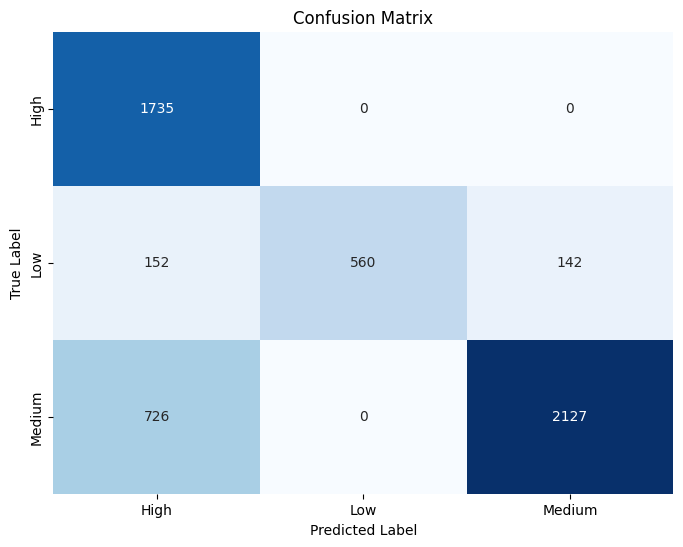

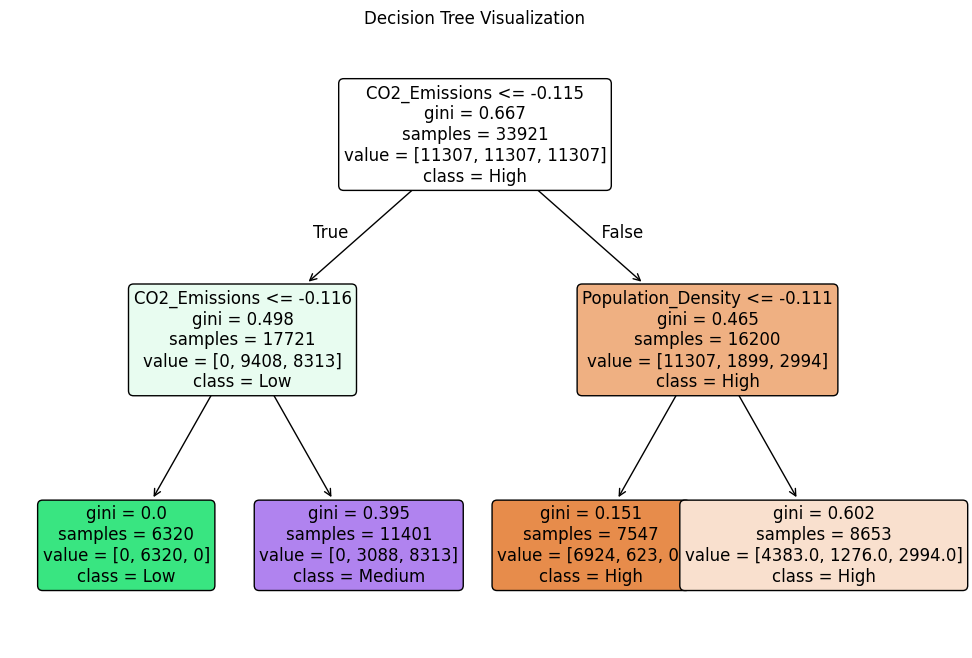

In [ ]:
# Membangun dan melatih model Decision Tree
dt_model = DecisionTreeClassifier(max_depth=2, min_samples_split=20, random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Membuat prediksi dengan model Decision Tree
dt_predictions = dt_model.predict(X_test_scaled)

# Mengevaluasi model Decision Tree
print("\nDecision Tree Model Evaluation:")
print(confusion_matrix(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

# Fungsi untuk memplot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Memvisualisasikan confusion matrix
plot_confusion_matrix(y_test, dt_predictions)

# Visualisasi Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model,
          feature_names=X.columns,
          class_names=np.unique(y).astype(str),
          filled=True,
          rounded=True,
          fontsize=12)
plt.title('Decision Tree Visualization')
plt.show()

## Random Forest


Random Forest Model Evaluation:
[[1735    0    0]
 [   0  854    0]
 [ 206  164 2483]]
              precision    recall  f1-score   support

        High       0.89      1.00      0.94      1735
         Low       0.84      1.00      0.91       854
      Medium       1.00      0.87      0.93      2853

    accuracy                           0.93      5442
   macro avg       0.91      0.96      0.93      5442
weighted avg       0.94      0.93      0.93      5442

Random Forest Accuracy: 0.93


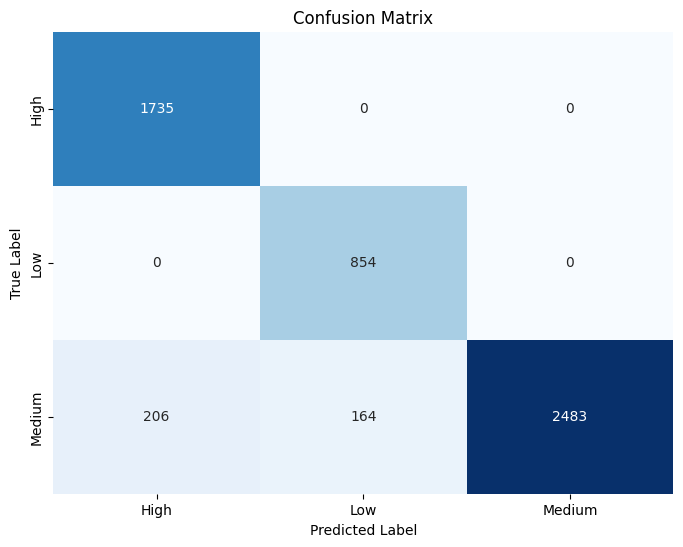

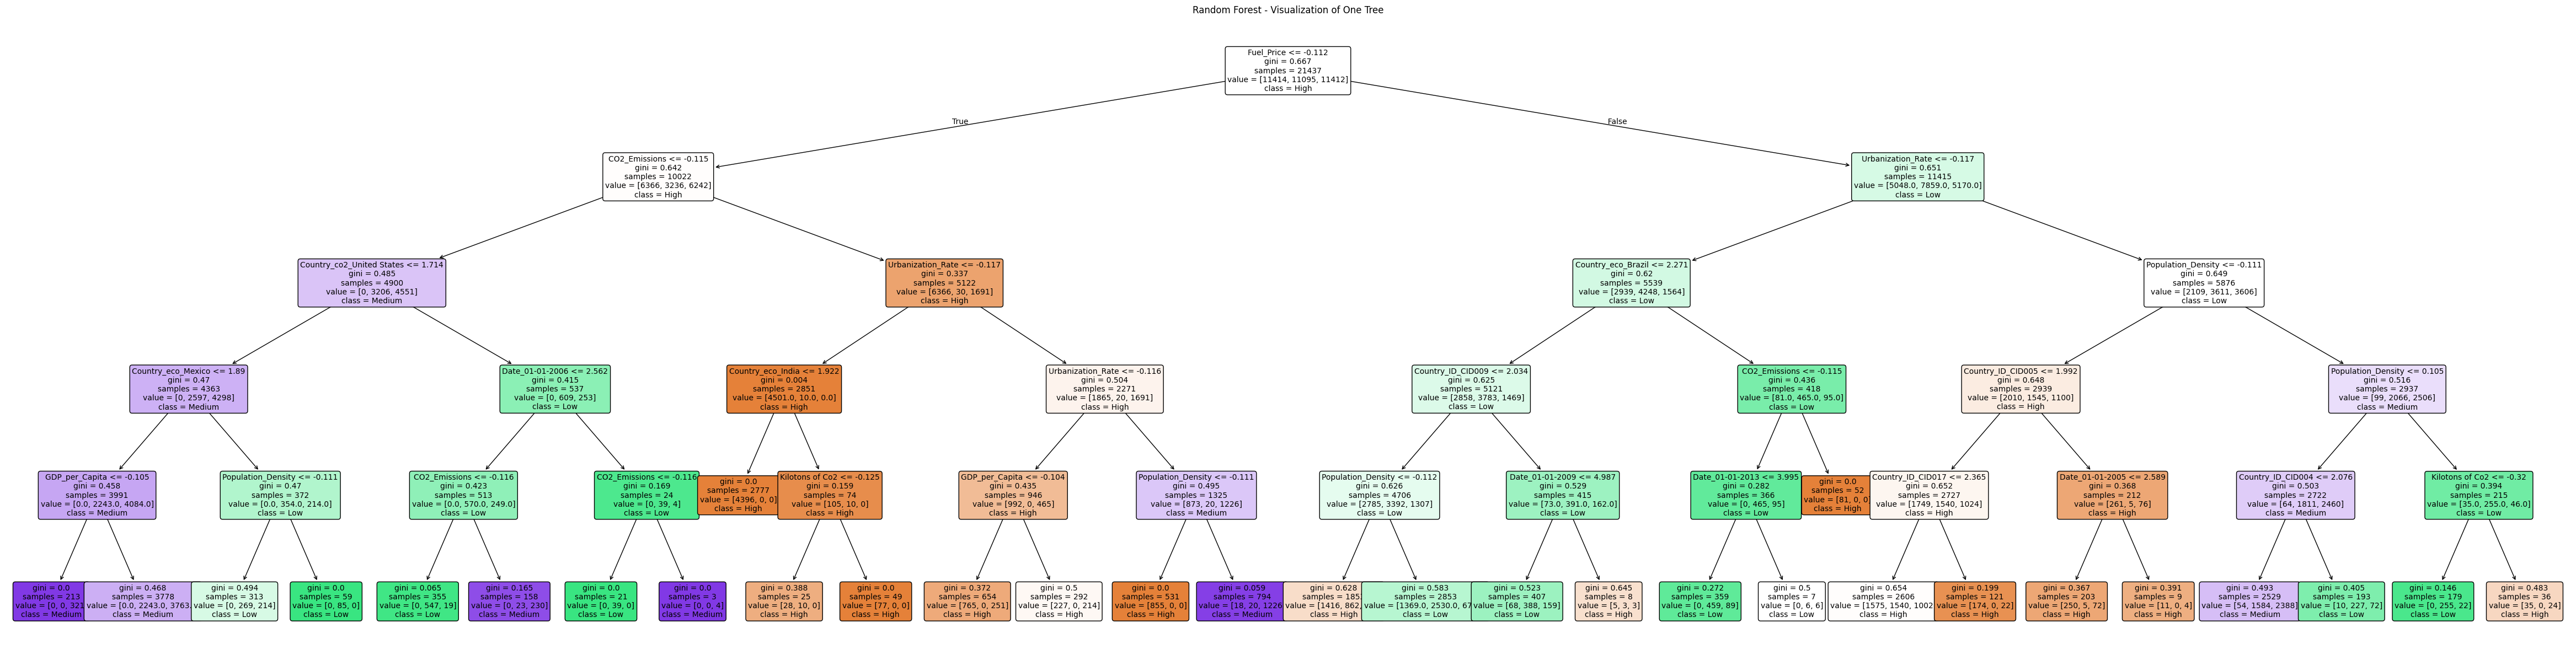

In [ ]:
# Membangun dan melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=10,random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Membuat prediksi dengan model Random Forest
rf_predictions = rf_model.predict(X_test_scaled)

# Mengevaluasi model Random Forest
print("\nRandom Forest Model Evaluation:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

# Memvisualisasikan confusion matrix untuk model Random Forest
plot_confusion_matrix(y_test, rf_predictions)

# Visualisasi salah satu pohon dalam Random Forest
plt.figure(figsize=(60, 15))
plot_tree(rf_model.estimators_[0], # Memilih pohon pertama dalam Random Forest
          feature_names=X.columns,
          class_names=np.unique(y).astype(str),
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Random Forest - Visualization of One Tree')
plt.show()

# Evaluasi

## Perbandingan Decision Tree dan Random Forest

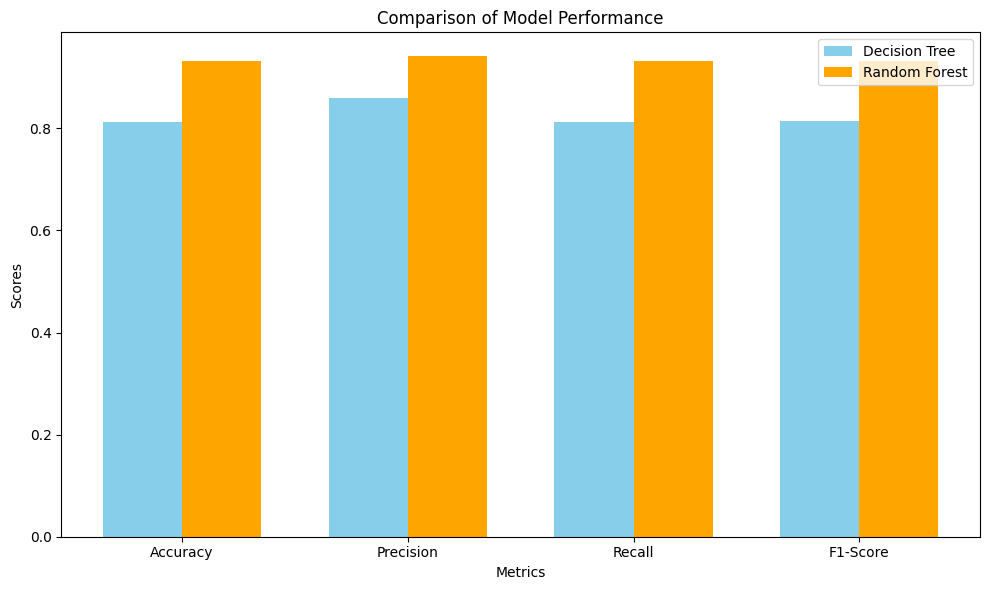

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Simpan metrik untuk kedua model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
dt_metrics = [
    dt_accuracy,
    precision_score(y_test, dt_predictions, average='weighted'),
    recall_score(y_test, dt_predictions, average='weighted'),
    f1_score(y_test, dt_predictions, average='weighted'),
]
rf_metrics = [
    rf_accuracy,
    precision_score(y_test, rf_predictions, average='weighted'),
    recall_score(y_test, rf_predictions, average='weighted'),
    f1_score(y_test, rf_predictions, average='weighted'),
]

# Plot perbandingan metrik
x = np.arange(len(metrics))  # Label posisi
width = 0.35  # Lebar bar

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, dt_metrics, width, label='Decision Tree', color='skyblue')
bar2 = ax.bar(x + width/2, rf_metrics, width, label='Random Forest', color='orange')

# Labeling
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()